In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [24]:
df = pd.read_csv("adult.csv")

In [57]:
print(f"Kształt danych: {df.shape}")
print(f"\nPierwsze 5 wierszy:")
print(df.head())
print(f"\nInformacje o kolumnach:")
print(df.info())
print(f"\nBrakujące wartości:")
print(df.isnull().sum())

Kształt danych: (32561, 15)

Pierwsze 5 wierszy:
   age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K

ROZKŁAD ZMIENNEJ DOCELOWEJ
income
<=50K    24720
>50K      7841
Name: count, dtype: int64

Proporcje:
income
<=50K    0.75919
>50K     0.24081
Name: proportion, dtype: float64


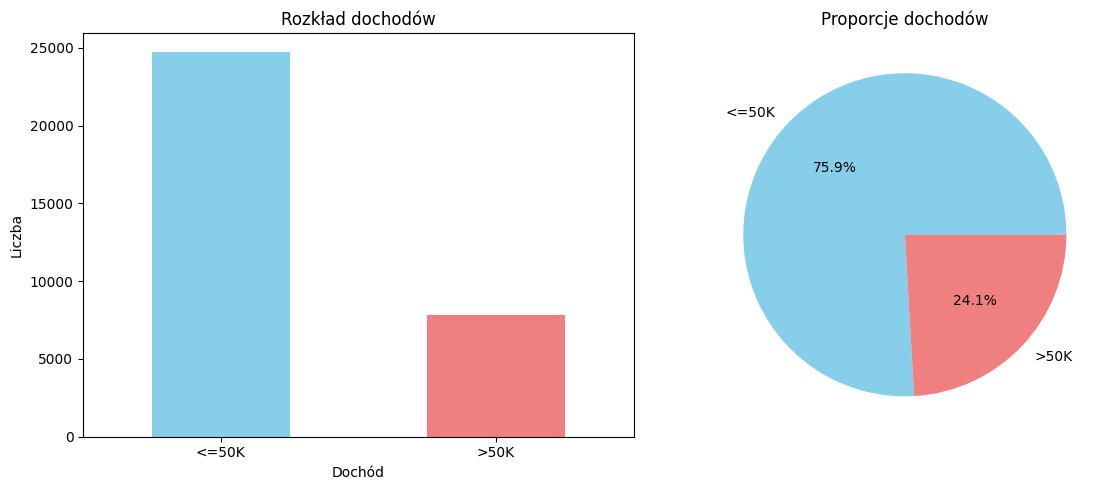

In [58]:
# ROZKŁAD ZMIENNEJ DOCELOWEJ
print("ROZKŁAD ZMIENNEJ DOCELOWEJ")
print("="*50)
print(df['income'].value_counts())
print(f"\nProporcje:")
print(df['income'].value_counts(normalize=True))

# Wizualizacja
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Wykres słupkowy
df['income'].value_counts().plot(kind='bar', ax=ax1, color=['skyblue', 'lightcoral'])
ax1.set_title('Rozkład dochodów')
ax1.set_xlabel('Dochód')
ax1.set_ylabel('Liczba')
ax1.tick_params(axis='x', rotation=0)

# Wykres kołowy
df['income'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%', 
                                colors=['skyblue', 'lightcoral'])
ax2.set_title('Proporcje dochodów')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

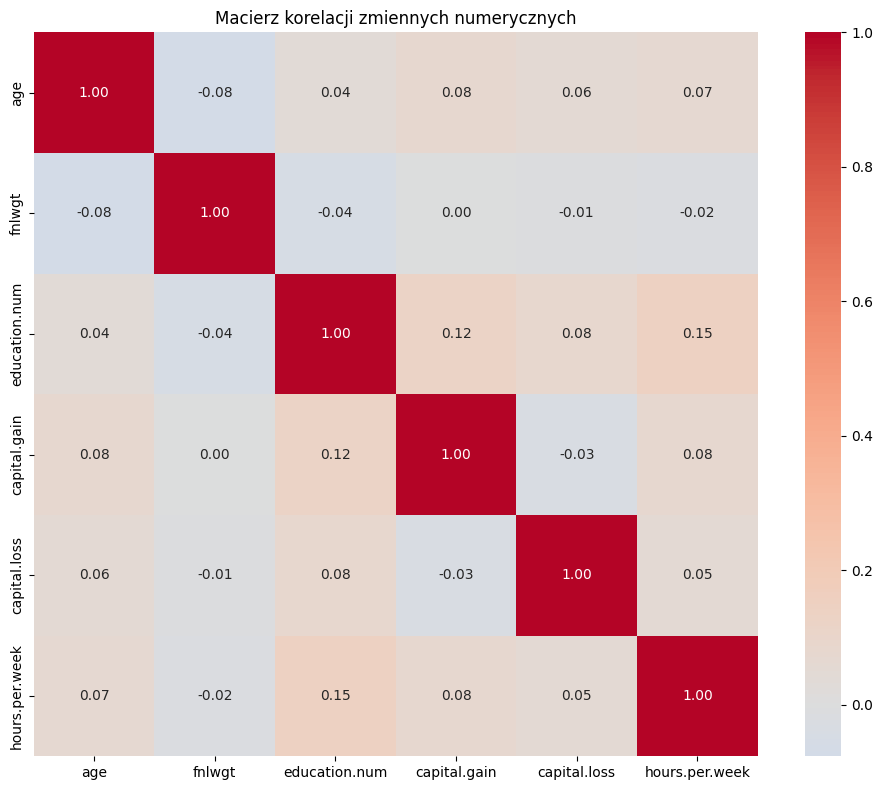

In [61]:
# MACIERZ KORELACJI ZMIENNYCH NUMERYCZNYCH

numeric_cols = df.select_dtypes(include=[np.number]).columns

# Macierz korelacji
plt.figure(figsize=(10, 8))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Macierz korelacji zmiennych numerycznych')
plt.tight_layout()
plt.show()

In [62]:
# PREPROCESSING DANYCH
print("PREPROCESSING DANYCH")
print("="*50)

# Kopia danych
df_clean = df.copy()

df_clean = df_clean.dropna()
print(f"Kształt po usunięciu braków: {df_clean.shape}")

# Kodowanie zmiennej docelowej
df_clean['income_binary'] = (df_clean['income'] == '>50K').astype(int)
print(f"Rozkład Y: {df_clean['income_binary'].value_counts().to_dict()}")

# Przygotowanie X i y
X = df_clean.drop(['income', 'income_binary'], axis=1)
y = df_clean['income_binary']

# Identyfikacja typów kolumn
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Cechy numeryczne ({len(numeric_features)}): {numeric_features}")
print(f"Cechy kategoryczne ({len(categorical_features)}): {categorical_features}")

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# Podział danych
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Kształt po preprocessing:")
print(f"X_train: {X_train_processed.shape}")
print(f"X_test: {X_test_processed.shape}")

PREPROCESSING DANYCH
Kształt po usunięciu braków: (32561, 15)
Rozkład Y: {0: 24720, 1: 7841}
Cechy numeryczne (6): ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
Cechy kategoryczne (8): ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
Kształt po preprocessing:
X_train: (26048, 99)
X_test: (6513, 99)


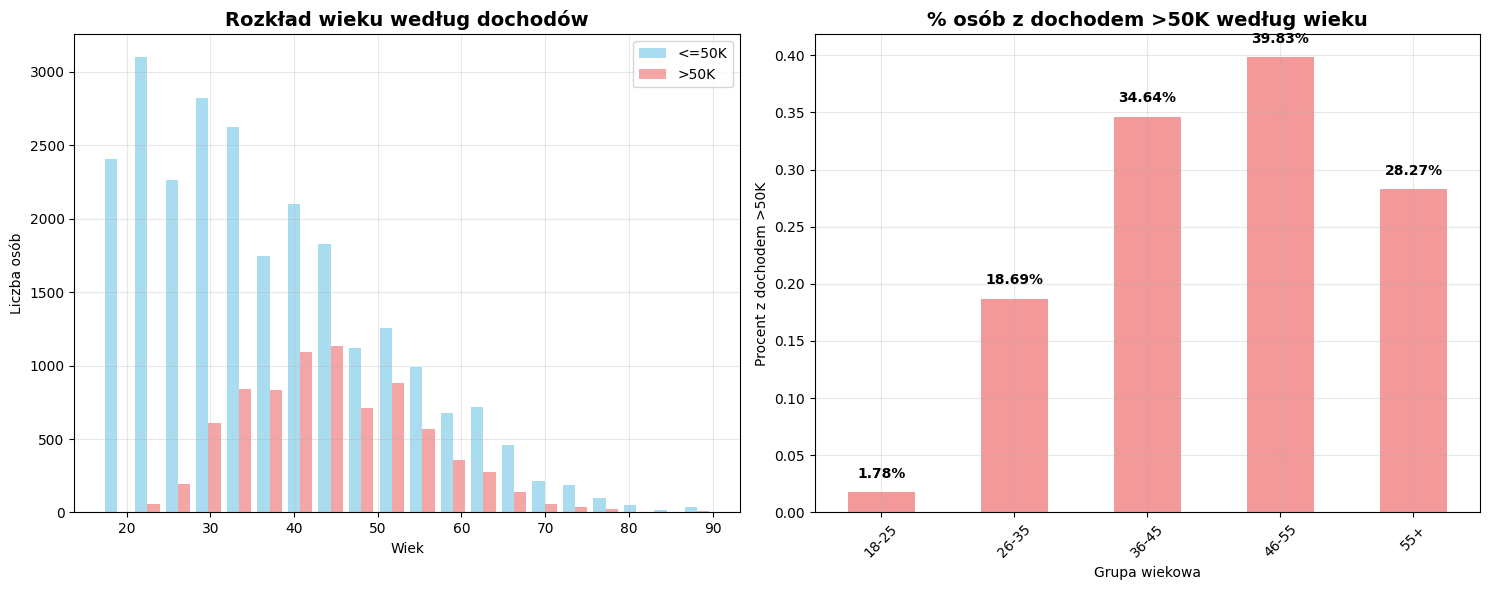

In [64]:
# ROZKŁAD WIEKU WEDŁUG GRUP DOCHODOWYCH
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram wieku według grup dochodowych
low_income_age = df_clean[df_clean['income'] == '<=50K']['age']
high_income_age = df_clean[df_clean['income'] == '>50K']['age']

ax1.hist([low_income_age, high_income_age], bins=20, alpha=0.7, 
         label=['<=50K', '>50K'], color=['skyblue', 'lightcoral'])
ax1.set_title('Rozkład wieku według dochodów', fontsize=14, fontweight='bold')
ax1.set_xlabel('Wiek')
ax1.set_ylabel('Liczba osób')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Proporcje wysokich dochodów według grup wiekowych
age_bins = pd.cut(df_clean['age'], bins=[0, 25, 35, 45, 55, 100], 
                  labels=['18-25', '26-35', '36-45', '46-55', '55+'])
age_income = pd.crosstab(age_bins, df_clean['income'], normalize='index')

if '>50K' in age_income.columns:
    age_income['>50K'].plot(kind='bar', ax=ax2, color='lightcoral', alpha=0.8)
    ax2.set_title('% osób z dochodem >50K według wieku', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Grupa wiekowa')
    ax2.set_ylabel('Procent z dochodem >50K')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    for i, v in enumerate(age_income['>50K']):
        ax2.text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



In [ ]:

# Definiowanie modeli
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
}

# Słownik na wyniki
results = {}

# Trenowanie i ewaluacja
print(f"{'Model':<20} {'Accuracy':<10} {'AUC':<10}")
print("-" * 40)

for name, model in models.items():
    # Trenowanie
    model.fit(X_train_processed, y_train)
    
    # Predykcje
    y_pred = model.predict(X_test_processed)
    y_prob = model.predict_proba(X_test_processed)[:, 1]
    
    # Metryki
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    # Wyświetlanie wyników
    results[name] = {
        'accuracy': accuracy,
        'auc': auc,
        'y_pred': y_pred,
        'y_prob': y_prob
    }
    
    print(f"{name:<20} {accuracy:<10.4f} {auc:<10.4f}")

# Najlepszy model
best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
print(f"Najlepszy model: {best_model[0]} (Accuracy: {best_model[1]['accuracy']:.4f})")

Model                Accuracy   AUC       
----------------------------------------
Logistic Regression  0.8553     0.9135    
Random Forest        0.8624     0.9115    
Random Forest        0.8624     0.9115    
Gradient Boosting    0.8702     0.9270    
XGBoost              0.8742     0.9340    
Najlepszy model: XGBoost (Accuracy: 0.8742)
Gradient Boosting    0.8702     0.9270    
XGBoost              0.8742     0.9340    
Najlepszy model: XGBoost (Accuracy: 0.8742)


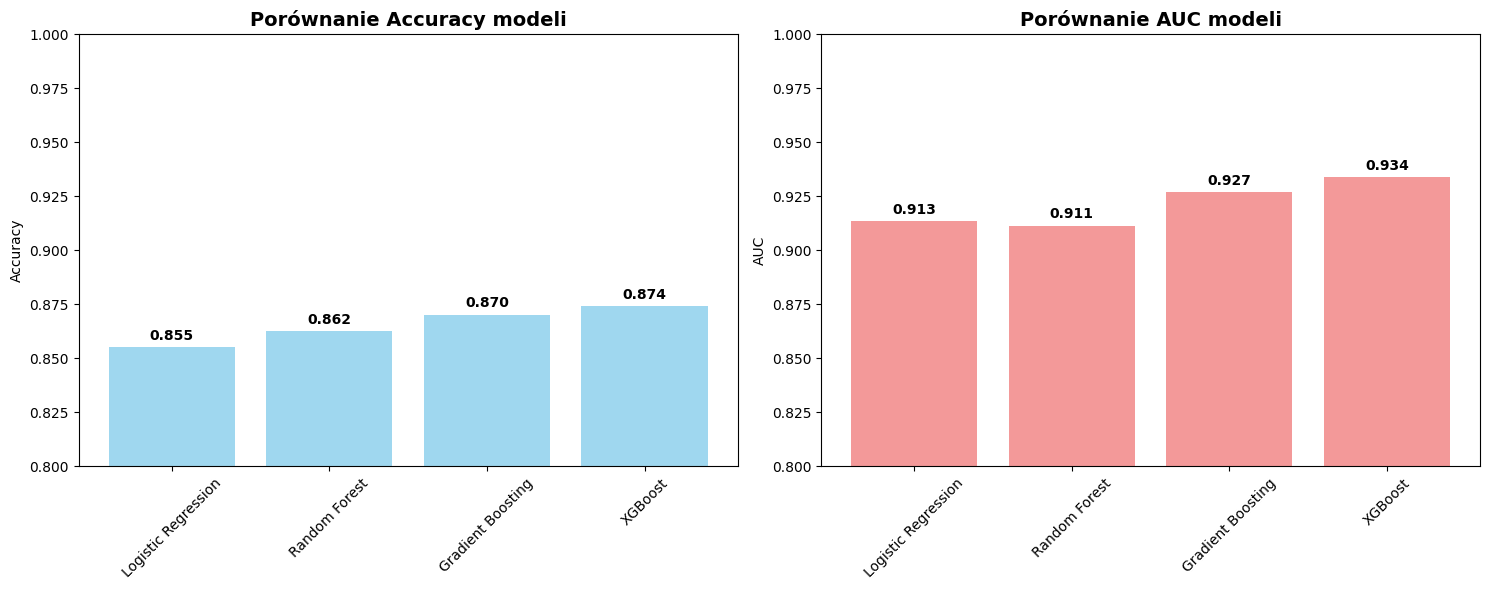

In [ ]:
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
aucs = [results[name]['auc'] for name in model_names]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Wykres Accuracy
bars1 = ax1.bar(model_names, accuracies, color='skyblue', alpha=0.8)
ax1.set_title('Porównanie Accuracy modeli', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.8, 1.0)
ax1.tick_params(axis='x', rotation=45)

for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Wykres AUC
bars2 = ax2.bar(model_names, aucs, color='lightcoral', alpha=0.8)
ax2.set_title('Porównanie AUC modeli', fontsize=14, fontweight='bold')
ax2.set_ylabel('AUC')
ax2.set_ylim(0.8, 1.0)
ax2.tick_params(axis='x', rotation=45)

for bar, auc in zip(bars2, aucs):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{auc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


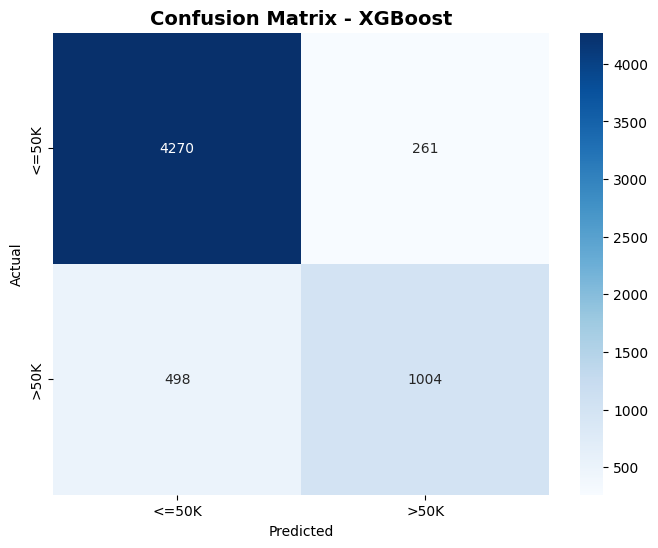

In [ ]:
best_model_name = best_model[0]
best_predictions = results[best_model_name]['y_pred']
cm = confusion_matrix(y_test, best_predictions)

# Wizualizacja confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['<=50K', '>50K'], 
            yticklabels=['<=50K', '>50K'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

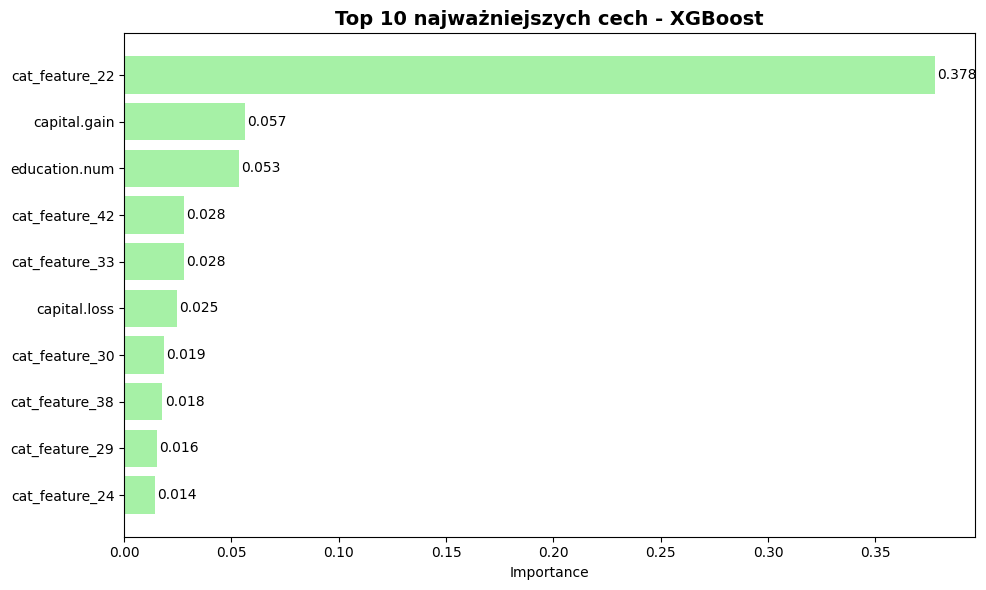

In [ ]:
# FEATURE IMPORTANCE (XGBOOST)
xgb_model = models['XGBoost']
feature_importance = xgb_model.feature_importances_
# Nazwy cech
feature_names = numeric_features + [f"cat_feature_{i}" for i in range(len(feature_importance) - len(numeric_features))]

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False).head(10)

# Wykres feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_df)), importance_df['importance'], color='lightgreen', alpha=0.8)
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Importance')
plt.title('Top 10 najważniejszych cech - XGBoost', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

for i, v in enumerate(importance_df['importance']):
    plt.text(v + 0.001, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()